# 고장예측 알고리즘 모델링

In [1]:
# Importing libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, LabelEncoder

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split


# 일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다.

# 또한, cross_val_score 함수에는 KFold의 매개변수를 제어할 수가 없으므로, 

# 따로 KFold 객체를 만들고 매개변수를 조정한 다음에 cross_val_score의 cv 매개변수에 넣어야 한다.

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, make_scorer, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

import warnings         # warnings : 버전 충돌 및 특정 예외 처리를 위해 불러온 내장 모듈
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import sklearn.metrics as metrics

In [3]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 1. EDA

## 2016.01.01 ~ 2016.12.31, 1년간 매 시간별 고장 유무가 기록된 데이터.

## 독립변수, 종속변수 정리

- 독립변수

    1. Date
    1. Temperature - 온도
    1. Humidity - 습도
    1. Operator - 공정라인
    1. Measure1 - Measure15 : 
    1. Hours Since Previous Failure - 이전 고장이후 흐른 시간
    1. Date.year - 년도(2016)
    1. Date.month - 월
    1. Date.day-of-month - 일
    1. Date.day-of-week - 주
    1. Date.hour - 시간
    1. Date.minute - 분 (0분고정)
    1. Date.second - (0초고정)



- Failure

    1. 고장 여부 ( No, Yes )

In [4]:
train = pd.read_csv('./BigML_Dataset.csv')

In [5]:
train

,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,﻿Date.year,﻿Date.month,﻿Date.day-of-month,﻿Date.day-of-week,﻿Date.hour,﻿Date.minute,﻿Date.second
0,2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,2016,1,1,5,0,0,0
1,2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,2016,1,1,5,1,0,0
2,2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,2016,1,1,5,2,0,0
3,2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,2016,1,1,5,3,0,0
4,2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,2016,1,1,5,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31 19:00:00,66,79,Operator8,937,0,2,1875,1719,219,748,1901,819,546,901,1512,1477,537,410,7,No,2016,12,31,6,19,0,0
8780,2016-12-31 20:00:00,60,77,Operator8,379,3,0,814,1990,1606,1346,962,875,1067,608,251,1476,522,943,8,No,2016,12,31,6,20,0,0
8781,2016-12-31 21:00:00,61,77,Operator8,595,3,1,1659,1134,1314,907,1119,1623,272,1149,1951,1835,1554,200,9,No,2016,12,31,6,21,0,0
8782,2016-12-31 22:00:00,72,81,Operator8,1038,3,2,254,1400,564,216,1011,1909,502,470,1331,1696,229,1192,10,No,2016,12,31,6,22,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 28 columns):
Date                            8784 non-null object
Temperature                     8784 non-null int64
Humidity                        8784 non-null int64
Operator                        8784 non-null object
Measure1                        8784 non-null int64
Measure2                        8784 non-null int64
Measure3                        8784 non-null int64
Measure4                        8784 non-null int64
Measure5                        8784 non-null int64
Measure6                        8784 non-null int64
Measure7                        8784 non-null int64
Measure8                        8784 non-null int64
Measure9                        8784 non-null int64
Measure10                       8784 non-null int64
Measure11                       8784 non-null int64
Measure12                       8784 non-null int64
Measure13                       8784 non-null int64
Measure

In [7]:
train.describe()

,Temperature,Humidity,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,﻿Date.year,﻿Date.month,﻿Date.day-of-month,﻿Date.day-of-week,﻿Date.hour,﻿Date.minute,﻿Date.second
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.0,8784.000000,8784.000000,8784.000000,8784.000000,8784.0,8784.0
mean,64.026412,83.337090,1090.900387,1.489868,0.999203,1071.629895,1075.822860,1076.023793,1086.897086,1077.277209,1082.014572,1082.403005,1088.719148,1088.329349,1076.755806,1088.307377,1082.392304,217.341872,2016.0,6.513661,15.756831,4.008197,11.500000,0.0,0.0
std,2.868833,4.836256,537.097769,1.115605,0.816473,536.518466,533.158826,534.004966,538.195156,537.187671,532.983115,537.582829,534.995992,533.299486,535.111353,537.264847,537.527604,151.751750,0.0,3.451430,8.812031,1.998047,6.922581,0.0,0.0
min,5.000000,65.000000,155.000000,0.000000,0.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,1.000000,2016.0,1.000000,1.000000,1.000000,0.000000,0.0,0.0
25%,62.000000,80.000000,629.000000,0.000000,0.000000,608.750000,606.000000,623.000000,621.000000,612.000000,631.000000,619.000000,627.000000,627.000000,609.000000,617.000000,614.000000,90.000000,2016.0,4.000000,8.000000,2.000000,5.750000,0.0,0.0
50%,64.000000,83.000000,1096.000000,1.000000,1.000000,1058.000000,1077.000000,1072.000000,1089.000000,1074.000000,1078.000000,1080.000000,1093.000000,1082.000000,1067.000000,1088.500000,1076.000000,195.000000,2016.0,7.000000,16.000000,4.000000,11.500000,0.0,0.0
75%,66.000000,87.000000,1555.000000,2.000000,2.000000,1533.000000,1541.000000,1537.000000,1558.000000,1541.000000,1532.000000,1547.000000,1550.000000,1552.000000,1539.000000,1560.000000,1550.000000,324.000000,2016.0,10.000000,23.000000,6.000000,17.250000,0.0,0.0
max,78.000000,122.000000,2011.000000,3.000000,2.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,666.000000,2016.0,12.000000,31.000000,7.000000,23.000000,0.0,0.0


In [8]:
train.describe(include=['O'])

,Date,Operator,Failure
count,8784,8784,8784
unique,8784,8,2
top,2016-12-23 05:00:00,Operator2,No
freq,1,1952,8703


In [9]:
train.columns

Index(['Date', 'Temperature', 'Humidity', 'Operator', 'Measure1', 'Measure2',
       'Measure3', 'Measure4', 'Measure5', 'Measure6', 'Measure7', 'Measure8',
       'Measure9', 'Measure10', 'Measure11', 'Measure12', 'Measure13',
       'Measure14', 'Measure15', 'Hours Since Previous Failure', 'Failure',
       '﻿Date.year', '﻿Date.month', '﻿Date.day-of-month', '﻿Date.day-of-week',
       '﻿Date.hour', '﻿Date.minute', '﻿Date.second'],
      dtype='object')

In [10]:
# train.drop('﻿Date.year', axis = 1, inplace = True)

In [11]:
train.rename(columns= {'﻿Date.year':2, '﻿Date.day-of-week':3, '﻿Date.minute':4, '﻿Date.second':5}, inplace = True)

In [12]:
train.head()

,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,2,﻿Date.month,﻿Date.day-of-month,3,﻿Date.hour,4,5
0,2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,2016,1,1,5,0,0,0
1,2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,2016,1,1,5,1,0,0
2,2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,2016,1,1,5,2,0,0
3,2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,2016,1,1,5,3,0,0
4,2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,2016,1,1,5,4,0,0


In [13]:
#  Date : 중복된 정보이기 때문에 삭제.
#  Date.year : 중복된 정보이기 때문에 삭제
#  Date.day-of-week : 중복된 정보이기 때문에 삭제
#  Date.minute : 0 값만 있기 때문에 삭제
#  Date.second : 0 값만 있기 때문에 삭제

train.drop([2,3,4,5], inplace = True, axis = 1)

In [14]:
train.head()

,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,﻿Date.month,﻿Date.day-of-month,﻿Date.hour
0,2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,1,1,0
1,2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,1,1,1
2,2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,1,1,2
3,2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,1,1,3
4,2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,1,1,4


In [15]:
# 분석의 편의를 위해 변수명 변경

train.rename(columns= {'﻿Date.month':'month', '﻿Date.hour':'hour', '﻿Date.day-of-month':'day'}, inplace = True)

In [16]:
train.head()

,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,month,day,hour
0,2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,1,1,0
1,2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,1,1,1
2,2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,1,1,2
3,2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,1,1,3
4,2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,1,1,4


## 1-1. 공정라인별 고장빈도 확인

In [17]:
train['Failure'].value_counts()

No     8703
Yes      81
Name: Failure, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

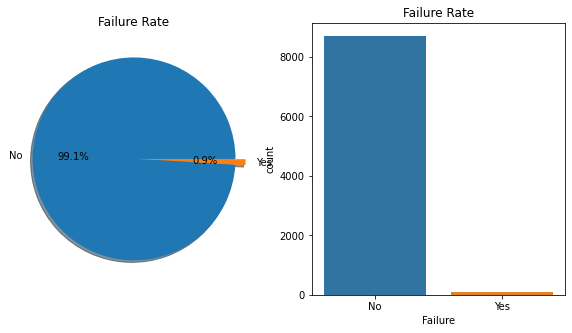

In [18]:
f, ax = plt.subplots(1, 2, figsize = (10, 5))

train['Failure'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('Failure Rate')
ax[0].set_ylabel('')
sns.countplot('Failure', data = train, ax = ax[1])
ax[1].set_title('Failure Rate')

plt.show()

### 고장률은 약 0.9%

In [19]:
# 공정라인은 1~8

train['Operator'].unique()

array(['Operator1', 'Operator3', 'Operator5', 'Operator2', 'Operator4',
       'Operator6', 'Operator7', 'Operator8'], dtype=object)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Operator1'),
  Text(1, 0, 'Operator3'),
  Text(2, 0, 'Operator5'),
  Text(3, 0, 'Operator2'),
  Text(4, 0, 'Operator4'),
  Text(5, 0, 'Operator6'),
  Text(6, 0, 'Operator7'),
  Text(7, 0, 'Operator8')])

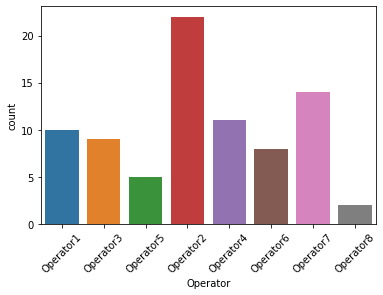

In [20]:
# 라인별 고장빈도 확인

sns.countplot(train['Operator'].loc[train['Failure'] == 'Yes'])
plt.xticks(rotation = 45)

In [21]:
# 라인별 

train['Operator'].loc[train['Failure'] == 'Yes'].value_counts()

Operator2    22
Operator7    14
Operator4    11
Operator1    10
Operator3     9
Operator6     8
Operator5     5
Operator8     2
Name: Operator, dtype: int64

In [22]:
Op_F = train['Operator'].loc[train['Failure'] == 'Yes'].value_counts()
Op_T = train['Operator'].loc[train['Failure'] == 'No'].value_counts()
print('고장 Shape:{0}, 정상 Shape:{1}'.format(Op_F.shape , Op_T.shape))

print(' 공정라인별 레이블 값 분포 비율')
print(Op_F/Op_T)

고장 Shape:(8,), 정상 Shape:(8,)
 공정라인별 레이블 값 분포 비율
Operator1    0.010352
Operator2    0.011399
Operator3    0.009307
Operator4    0.011399
Operator5    0.005149
Operator6    0.008264
Operator7    0.014553
Operator8    0.002053
Name: Operator, dtype: float64


### 고장빈도는 라인2에서 22번으로 제일 높고, 
### 고장률은 라인7에서 0.014% 로 제일 높다.

## 1-2. 시간대별 고장여부에 대한 규칙성 파악하기

### 월별 고장빈도

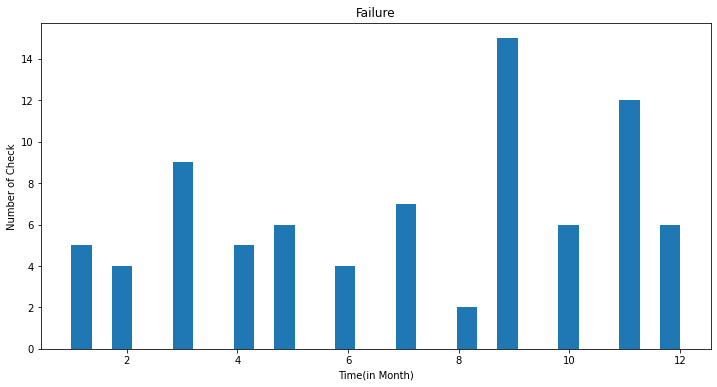

In [23]:
# 월별 고장빈도

f,ax1 = plt.subplots(sharex=False, figsize=(12,6))

ax1.hist(train.month[train.Failure=='Yes'], bins=30)
ax1.set_title('Failure')
plt.xlabel('Time(in Month)')
plt.ylabel('Number of Check')
plt.show()

# 9월, 11월 고장빈도가 높음. 따라서 월별 일자에 대한 고장빈도 확인필요.

In [24]:
train.columns

Index(['Date', 'Temperature', 'Humidity', 'Operator', 'Measure1', 'Measure2',
       'Measure3', 'Measure4', 'Measure5', 'Measure6', 'Measure7', 'Measure8',
       'Measure9', 'Measure10', 'Measure11', 'Measure12', 'Measure13',
       'Measure14', 'Measure15', 'Hours Since Previous Failure', 'Failure',
       'month', 'day', 'hour'],
      dtype='object')

## 1-3. 정상/고장 컬럼간 값 분포

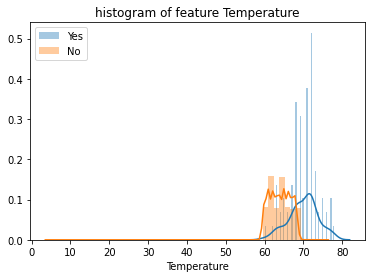

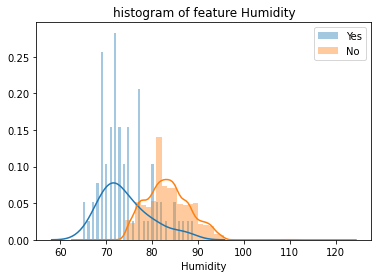

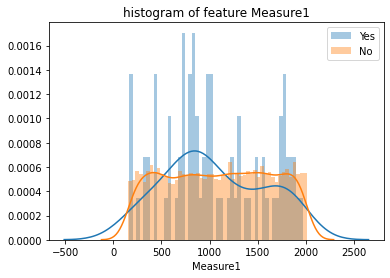

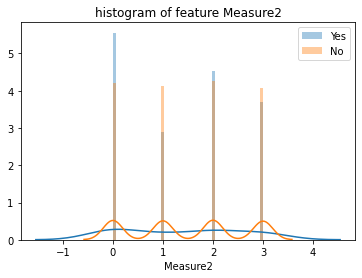

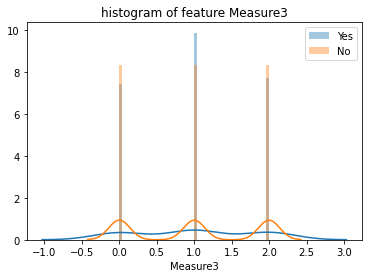

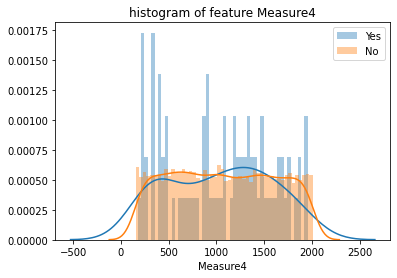

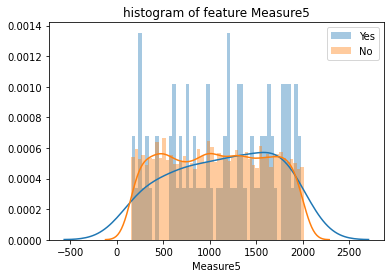

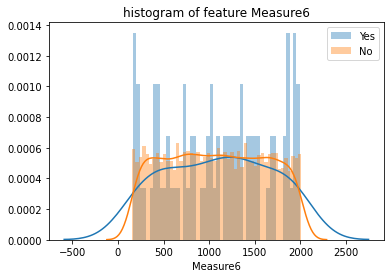

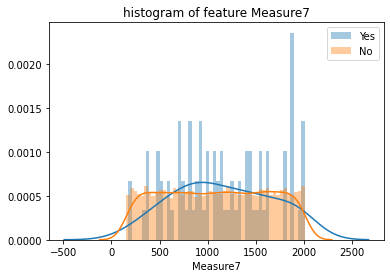

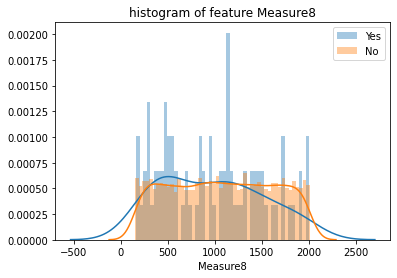

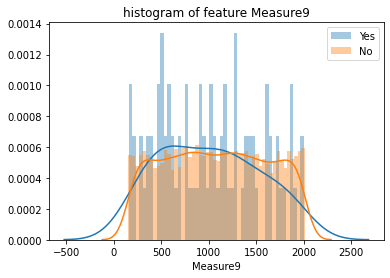

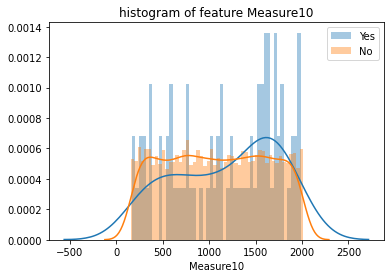

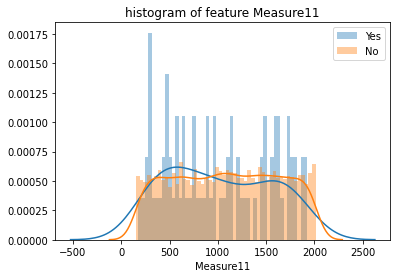

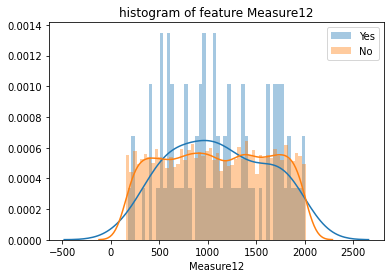

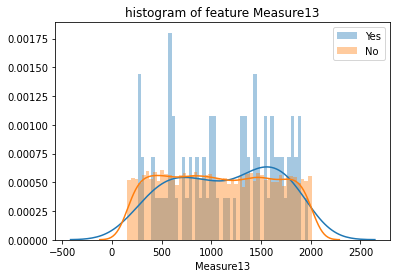

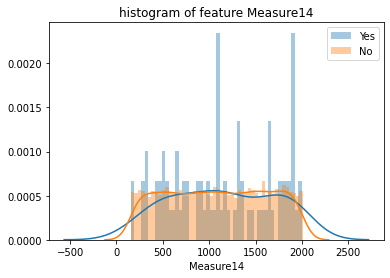

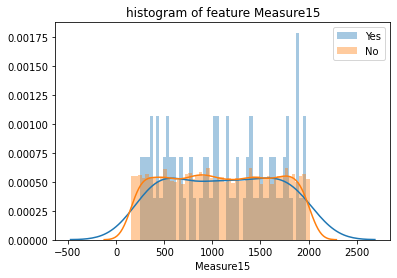

In [25]:
# 정상/고장 컬럼간 값 분포(1)

v_features = ['Temperature', 'Humidity', 'Measure1', 'Measure2',
       'Measure3', 'Measure4', 'Measure5', 'Measure6', 'Measure7', 'Measure8',
       'Measure9', 'Measure10', 'Measure11', 'Measure12', 'Measure13',
       'Measure14', 'Measure15']

for cnt, col in enumerate(train[v_features]):
    sns.distplot(train[col][train.Failure=='Yes'], bins=50)
    sns.distplot(train[col][train.Failure=='No'], bins=50)
    plt.legend(['Yes','No'])
    plt.title('histogram of feature '+str(col))
    plt.show()

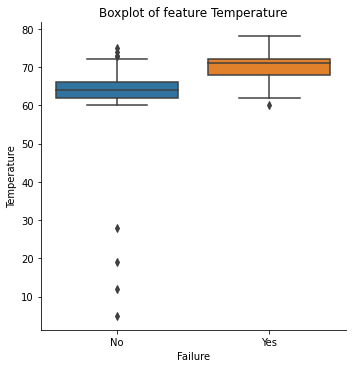

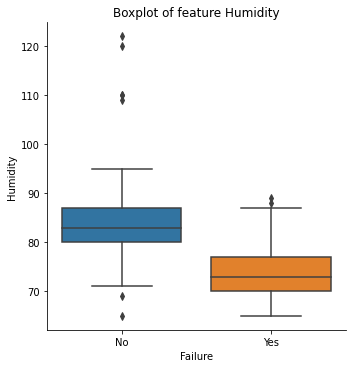

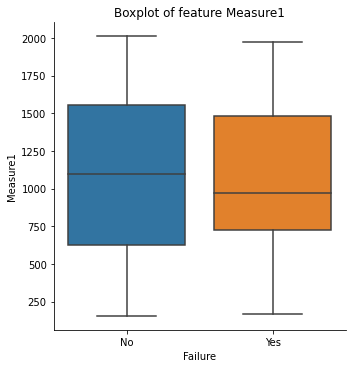

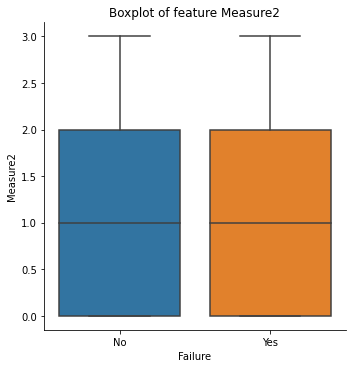

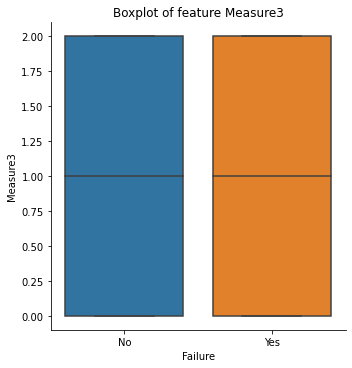

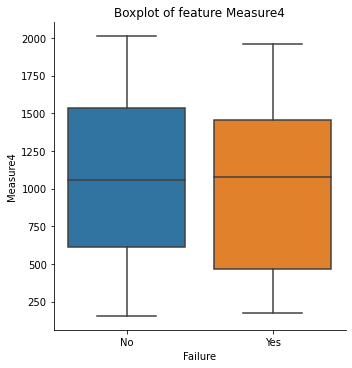

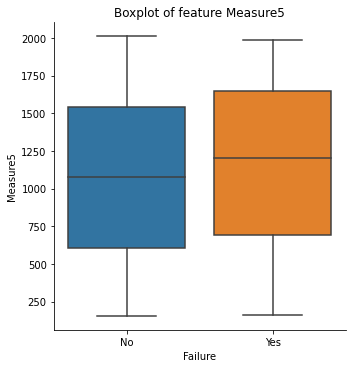

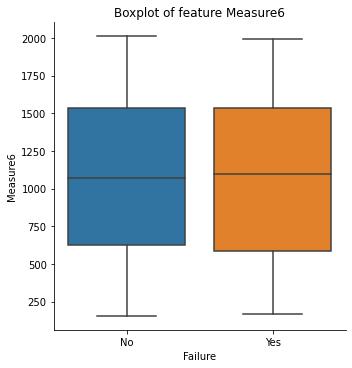

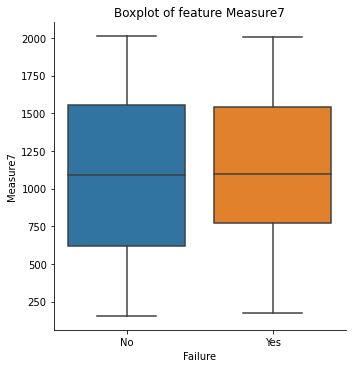

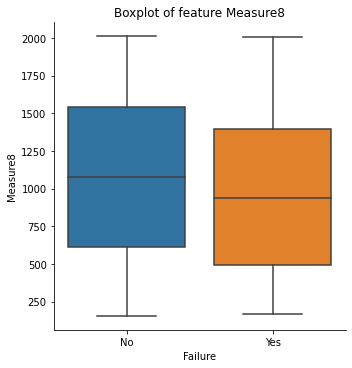

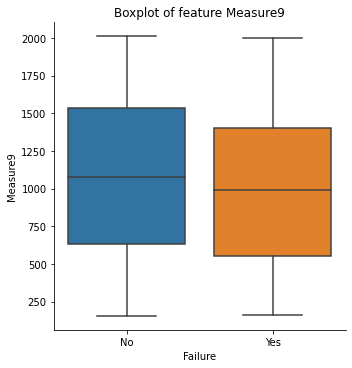

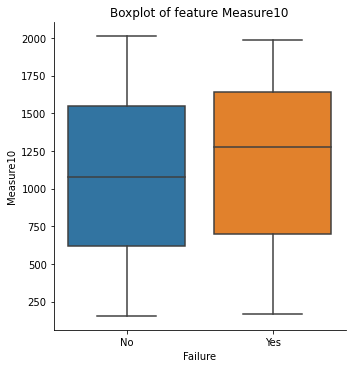

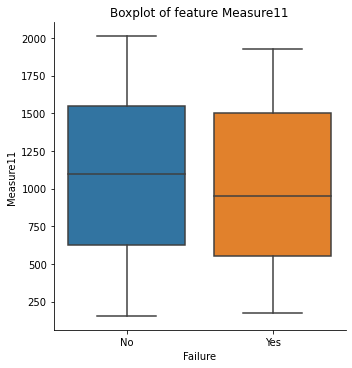

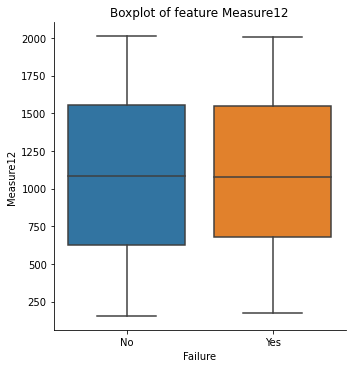

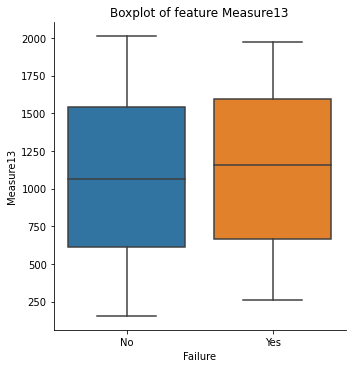

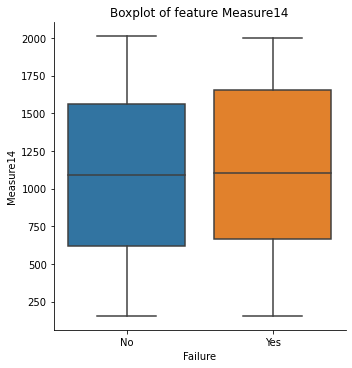

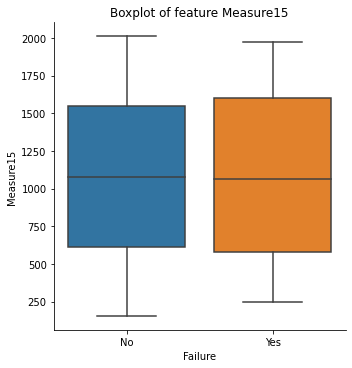

In [26]:
# 정상/고장 컬럼간 값 분포(2)

v_features = ['Temperature', 'Humidity', 'Measure1', 'Measure2',
       'Measure3', 'Measure4', 'Measure5', 'Measure6', 'Measure7', 'Measure8',
       'Measure9', 'Measure10', 'Measure11', 'Measure12', 'Measure13',
       'Measure14', 'Measure15']

for cnt, col in enumerate(train[v_features]):
    sns.catplot(y = col, x = 'Failure', data = train, kind = 'box')
    plt.title('Boxplot of feature '+str(col))
    plt.show()

### 정상/고장 은 온도와 습도 컬럼에서 분포차이가 가장 크다.

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Operator1'),
  Text(1, 0, 'Operator3'),
  Text(2, 0, 'Operator5'),
  Text(3, 0, 'Operator2'),
  Text(4, 0, 'Operator4'),
  Text(5, 0, 'Operator6'),
  Text(6, 0, 'Operator7'),
  Text(7, 0, 'Operator8')])

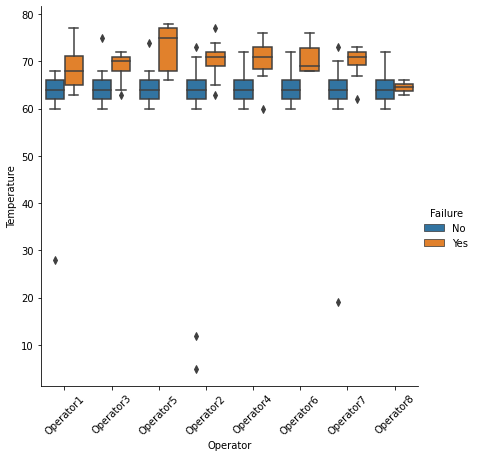

In [27]:
# 공정라인별 고장여부에 따른 온도 분포

sns.catplot('Operator', 'Temperature', kind = 'box', hue = 'Failure', data = train, height = 6)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Operator1'),
  Text(1, 0, 'Operator3'),
  Text(2, 0, 'Operator5'),
  Text(3, 0, 'Operator2'),
  Text(4, 0, 'Operator4'),
  Text(5, 0, 'Operator6'),
  Text(6, 0, 'Operator7'),
  Text(7, 0, 'Operator8')])

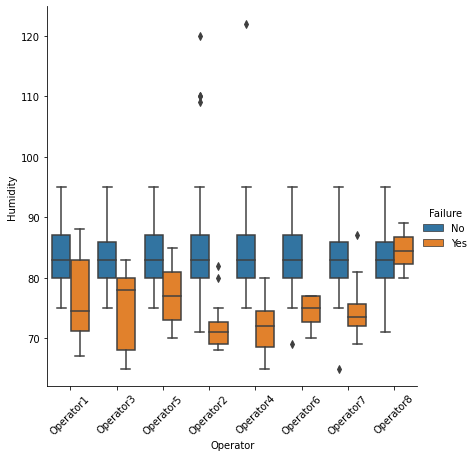

In [28]:
# 공정 라인별 고장여부에 따른 습도 분포

sns.catplot('Operator', 'Humidity', kind = 'box', hue = 'Failure', data = train, height = 6)
plt.xticks(rotation = 45)

## 공정라인8을 제외한 나머지 공정라인에서는 온도와 습도의 일정 수준 유지가 필요해보임.

# 2. 공정라인별 시계열 시각화

In [29]:
train_copy = train.copy()

In [30]:
train_copy.index = train_copy['Date']
train_copy.set_index('Date', inplace = True)
train_copy.head()

,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,month,day,hour
Date,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,1,1,0
2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,1,1,1
2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,1,1,2
2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,1,1,3
2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,1,1,4


## 고장이 발생하는 시간의 간격

## 2-1. 2번 공정라인

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


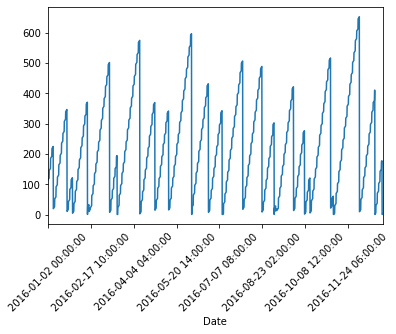

In [31]:
train_copy['Hours Since Previous Failure'].loc[train_copy['Operator'] == 'Operator2'].plot()
plt.xticks(rotation = 45)
plt.show()

## 2-2. 7번 공정라인

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


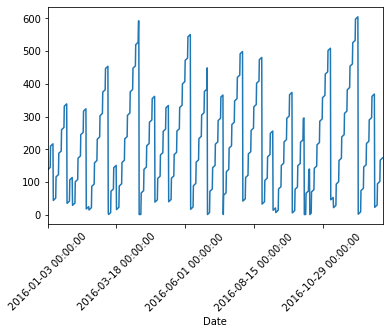

In [32]:
train_copy['Hours Since Previous Failure'].loc[train_copy['Operator'] == 'Operator7'].plot()
plt.xticks(rotation = 45)
plt.show()

# 3. 기계학습을 위한 전처리

In [33]:
train.head()

,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,Measure9,Measure10,Measure11,Measure12,Measure13,Measure14,Measure15,Hours Since Previous Failure,Failure,month,day,hour
0,2016-01-01 00:00:00,67,82,Operator1,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90,No,1,1,0
1,2016-01-01 01:00:00,68,77,Operator1,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91,No,1,1,1
2,2016-01-01 02:00:00,64,76,Operator1,1406,1,1,511,1577,1121,1948,1882,1301,273,1927,1123,717,1518,1689,92,No,1,1,2
3,2016-01-01 03:00:00,63,80,Operator1,550,1,1,1754,1834,1413,1151,945,1312,1494,1755,1434,502,1336,711,93,No,1,1,3
4,2016-01-01 04:00:00,65,81,Operator1,1928,1,2,1326,1082,233,1441,1736,1033,1549,802,1819,1616,1507,507,94,No,1,1,4


In [34]:
# 공장라인 더미변수

df1 = pd.get_dummies(train['Operator'], drop_first = False)
train = pd.concat([train, df1], axis=1)
train.drop(['Date', 'hour', 'day', 'Operator'], axis = 1, inplace = True)

# 4. 비지도학습 분류 알고리즘 만들기

# 4-1. 비지도학습 - Isolation Forest

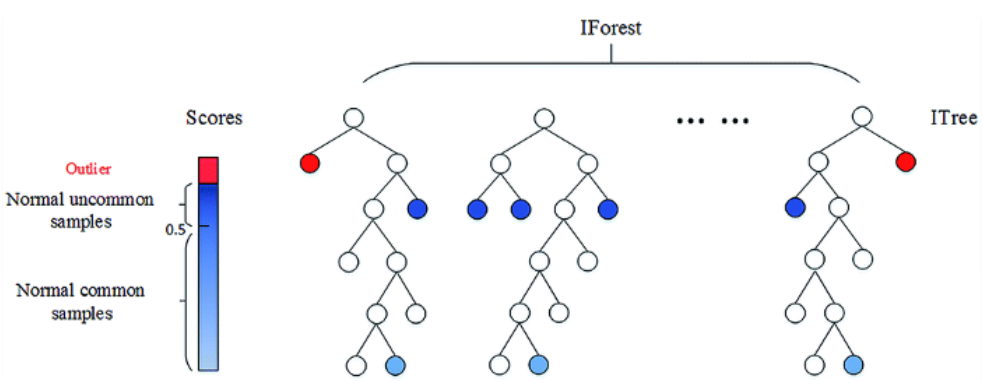

### - 다차원 데이터셋에서 효율적으로 작동하는 아웃라이어 제거 방법
### - 의사결정 트리기반 이상탐지 기법
### - 랜덤하게 컬럼을 선택하고, 선택된 컬럼의 최대값과 최소값을 분리하는 값을 랜덤으로 선택하는 방법

In [35]:
y = train['Failure']
y.shape

(8784,)

In [36]:
X = train.drop(['Failure'], axis=1)
X.shape

(8784, 27)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(7027, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
No     0.99075
Yes    0.00925
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
No     0.990894
Yes    0.009106
Name: Failure, dtype: float64


In [38]:
from sklearn.ensemble import IsolationForest

iso_Forest = IsolationForest(n_estimators=1000, contamination=0.09, random_state=42)
iso_Forest.fit(X)
pred_outlier = iso_Forest.predict(X)

In [39]:
pred_outlier

array([ 1,  1,  1, ...,  1, -1,  1])

# 4-2. 차원축소후 2D, 3D 시각화

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3) 
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(X)
X_reduce = pca.fit_transform(X)

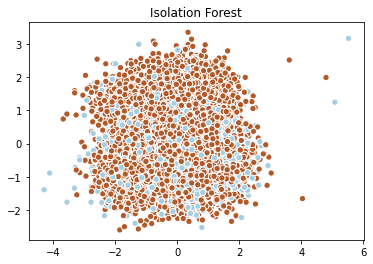

In [41]:
# plot 2d

plt.scatter(X_reduce[:,0], X_reduce[:,1], c=pred_outlier, cmap='Paired', s=40, edgecolors='white')
plt.title("Isolation Forest")
plt.show()

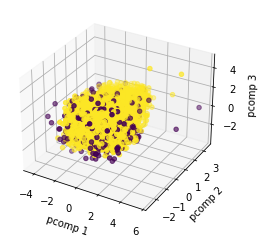

In [42]:
from mpl_toolkits.mplot3d import Axes3D

# plot 3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:,1], X_reduce[:,2], c=pred_outlier)
ax.set_xlabel('pcomp 1')
ax.set_ylabel('pcomp 2')
ax.set_zlabel('pcomp 3')
plt.show()

In [43]:
y = pd.DataFrame(y)

In [44]:
# 고장 = -1, 정상 = 1 로 변경
y.loc[y["Failure"] == "Yes","Failure"] = -1
y.loc[y["Failure"] == "No","Failure"] = 1

confusion matrix
 [[  34  757]
 [  47 7946]]
Accuracy:  0.9084699453551912
Recall:  0.9941198548730139
F1-Score:  0.9518447532343077
classification_report
               precision    recall  f1-score   support

          -1       0.42      0.04      0.08       791
           1       0.91      0.99      0.95      7993

    accuracy                           0.91      8784
   macro avg       0.67      0.52      0.51      8784
weighted avg       0.87      0.91      0.87      8784



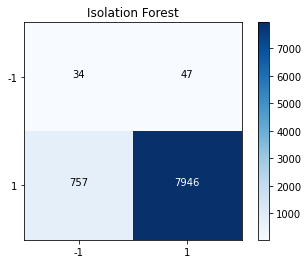

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

class_name = [-1, 1]
def plot_confusion_matrix(classes, pred, y_test, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


# 평가
print('confusion matrix\n', confusion_matrix(pred_outlier, y))
print('Accuracy: ',accuracy_score(pred_outlier, y))
print('Recall: ',recall_score(pred_outlier, y))
print('F1-Score: ',f1_score(pred_outlier, y))
print('classification_report\n', classification_report(pred_outlier, y))
plot_confusion_matrix(class_name, pred_outlier, y, title='Isolation Forest')

# - 분류성능이 부족하기 때문에 지도학습 알고리즘으로 변경

# 5. 지도학습 분류알고리즘 만들기

# 5-1. Random Forest

In [46]:
y = train['Failure']
y.shape

(8784,)

In [47]:
# 고장 = True, 정상 = False 로 변경

y.loc[y == "Yes"] = -1
y.loc[y == "No"] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
X = train.drop(['Failure'], axis=1)
X.shape

(8784, 27)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(7027, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
 1    0.99075
-1    0.00925
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


In [50]:
# Random forest

rf_cl = RandomForestClassifier(n_jobs = -1)
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

rf_cl_cv_pre = cross_val_score(rf_cl, X_train, y_train, cv = 10, scoring = 'precision', n_jobs=-1)
rf_cl_cv_rec = cross_val_score(rf_cl, X_train, y_train, cv = 10, scoring = 'recall', n_jobs=-1)
rf_cl_cv_f1 = cross_val_score(rf_cl, X_train, y_train, cv = 10, scoring = 'f1', n_jobs=-1)

print('Precision for random forest is ', metrics.precision_score(rf_cl_pred, y_test))
print('Recall for random forest is ', metrics.recall_score(rf_cl_pred, y_test))
print('F1_score for random forest is ', metrics.f1_score(rf_cl_pred, y_test))
print()
print('The cross validated precision for random forest is:', rf_cl_cv_pre.mean())
print('The cross validated recall for random forest is:', rf_cl_cv_rec.mean())
print('The cross validated f1_score for random forest is:', rf_cl_cv_f1.mean())

Precision for random forest is  1.0
Recall for random forest is  0.9977077363896848
F1_score for random forest is  0.9988525530694204

The cross validated precision for random forest is: 0.9971363054632485
The cross validated recall for random forest is: 0.999712849816125
The cross validated f1_score for random forest is: 0.9983501221263505


classification_report
               precision    recall  f1-score   support

          -1       0.75      1.00      0.86        12
           1       1.00      1.00      1.00      1745

    accuracy                           1.00      1757
   macro avg       0.88      1.00      0.93      1757
weighted avg       1.00      1.00      1.00      1757



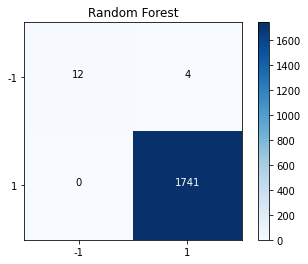

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

class_name = [-1, 1]
def plot_confusion_matrix(classes, pred, y_test, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, rf_cl_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


        
# 평가

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

# 5-2. 불균형 해결을 위한 오버샘플링 기법 적용

# 오버 샘플링
- RandomOverSampler: random sampler
- ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning
- SMOTE: Synthetic Minority Over-sampling Technique
- BoarderlineSMOTE
- SVMSMOTE

In [52]:
from imblearn.over_sampling import *

### RandomOverSampler
- Random Over Sampling은 소수 클래스의 데이터를 반복해서 넣는 것(replacement)이다. 가중치를 증가시키는 것과 비슷하다.

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [54]:
X_train, y_train = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)

In [55]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13924, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
-1    0.5
 1    0.5
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.75      1.00      0.86        12
           1       1.00      1.00      1.00      1745

    accuracy                           1.00      1757
   macro avg       0.88      1.00      0.93      1757
weighted avg       1.00      1.00      1.00      1757



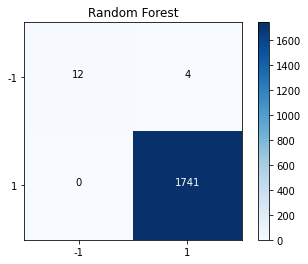

In [56]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

### ADASYN
- ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [58]:
X_train, y_train = ADASYN(random_state=0).fit_sample(X_train, y_train)

In [59]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13896, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
 1    0.501007
-1    0.498993
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.81      1.00      0.90        13
           1       1.00      1.00      1.00      1744

    accuracy                           1.00      1757
   macro avg       0.91      1.00      0.95      1757
weighted avg       1.00      1.00      1.00      1757



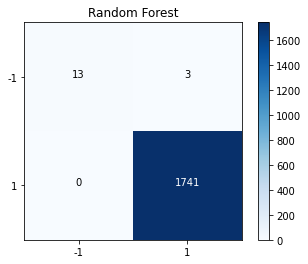

In [60]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

## BoarderlineSMOTE

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [62]:
X_train, y_train = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

In [63]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13924, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
-1    0.5
 1    0.5
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.69      1.00      0.81        11
           1       1.00      1.00      1.00      1746

    accuracy                           1.00      1757
   macro avg       0.84      1.00      0.91      1757
weighted avg       1.00      1.00      1.00      1757



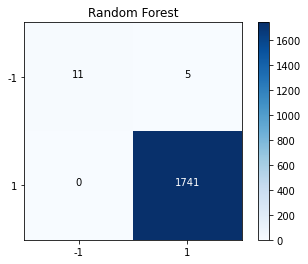

In [64]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

## SVM_SMOTE

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [66]:
X_train, y_train = SVMSMOTE(random_state=0).fit_sample(X_train, y_train)

In [67]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(11146, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
 1    0.624619
-1    0.375381
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.88      1.00      0.93        14
           1       1.00      1.00      1.00      1743

    accuracy                           1.00      1757
   macro avg       0.94      1.00      0.97      1757
weighted avg       1.00      1.00      1.00      1757



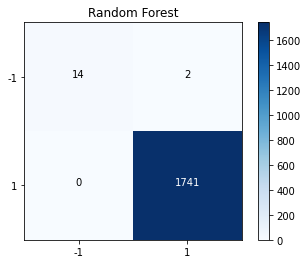

In [68]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

# 복합 샘플링¶
- SMOTEENN: SMOTE + ENN
- SMOTETomek: SMOTE + Tomek

In [69]:
from imblearn.combine import *

### SMOTE+ENN
- SMOTE+ENN 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [71]:
X_train, y_train = SMOTEENN(random_state=0).fit_sample(X_train, y_train)

In [72]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13054, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
-1    0.533323
 1    0.466677
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.81      0.93      0.87        14
           1       1.00      1.00      1.00      1743

    accuracy                           1.00      1757
   macro avg       0.91      0.96      0.93      1757
weighted avg       1.00      1.00      1.00      1757



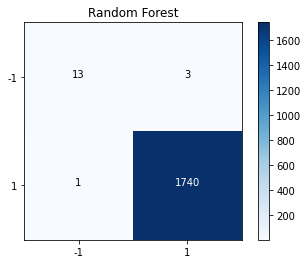

In [73]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

### SMOTE+Tomek¶
- SMOTE+Tomek 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 토멕링크 방법을 섞은 것이다.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# 분류학습시 stratify = target으로 설정해야함.

In [75]:
X_train, y_train = SMOTETomek(random_state=0).fit_sample(X_train, y_train)

In [76]:
# 추후 오버,언더,하이드리브 샘플링 적용시 레이블 값 분포를 보기위한 코드.

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13924, 27), 테스트 세트 Shape:(1757, 27)
 학습 세트 레이블 값 분포 비율
-1    0.5
 1    0.5
Name: Failure, dtype: float64

 테스트 세트 레이블 값 분포 비율
 1    0.990894
-1    0.009106
Name: Failure, dtype: float64


classification_report
               precision    recall  f1-score   support

          -1       0.81      0.87      0.84        15
           1       1.00      1.00      1.00      1742

    accuracy                           1.00      1757
   macro avg       0.91      0.93      0.92      1757
weighted avg       1.00      1.00      1.00      1757



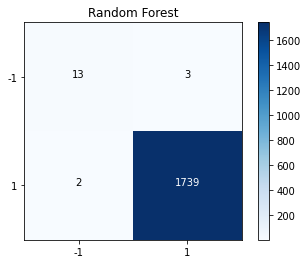

In [77]:
rf_cl.fit(X_train, y_train)
rf_cl_pred = rf_cl.predict(X_test)

print('classification_report\n', classification_report(rf_cl_pred, y_test))
plot_confusion_matrix(class_name, rf_cl_pred, y_test, title='Random Forest')

# 6. 최종모델선정

# 6-1. 선정기준

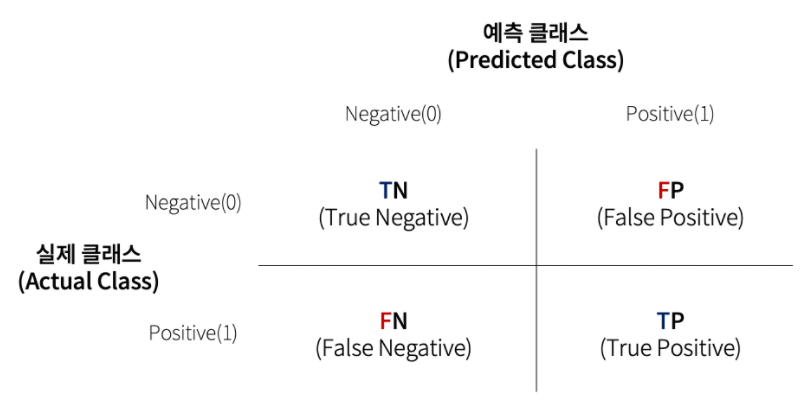

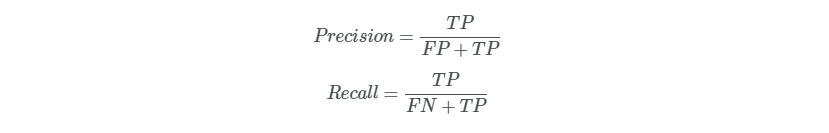

# - Case Study -

## 재현율(Recall)의 경우 다음과 같은 상황을 생각해보았습니다.

### 1. 고장인 상황을 고장으로 예측한 경우
### 2. 고장이 아닌 상황을 고장으로 예측한 경우
### 3. 고장인 상황을 정상으로 예측한 경우
### 4. 고장이 아닌 상황을 정상으로 예측한 경우




- 1번과 4번은 제대로 예측하였고, 2번과 3번은 공정관리에 치명적입니다. 가장 최악은 3번의 경우입니다. 모델의 판단 결과가 전체 공정관리에 영향을 미칠 수 있기 때문입니다.

- 때문에 재현율(Recall)이 가장 높은 모델을 최종선정하였습니다. 실제 고장인 상황 중에서 고장을 예측한 확률을 구하는 것입니다.

# 6-2. 최종모델

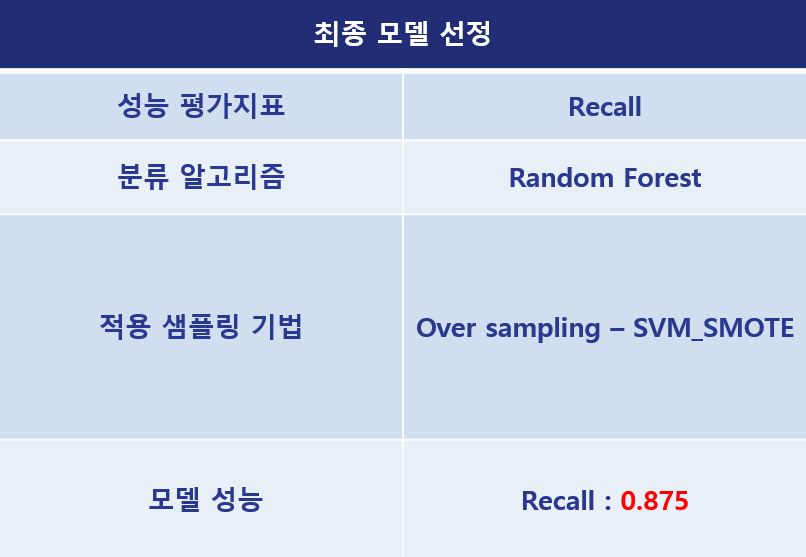